# 텍스트 유사도

- 쿼라 데이터 사용 (질의응답 시스템)  
- 비슷한 질문을 분류할 수 있다면, 미리 잘 작성된 답변을 중복 사용할 수 있게 된다.  
- 따라서 질문들이 서로 유사한지 유사하지 않은지 유사도를 판별해야 한다.  

## 데이터 EDA

In [6]:
!kaggle competitions download -c quora-question-pairs



  0%|          | 0.00/309M [00:00<?, ?B/s]
  0%|          | 1.00M/309M [00:00<00:56, 5.73MB/s]
  1%|          | 2.00M/309M [00:00<00:50, 6.43MB/s]
  1%|          | 3.00M/309M [00:00<00:45, 6.98MB/s]
  1%|1         | 4.00M/309M [00:00<00:44, 7.25MB/s]
  2%|1         | 5.00M/309M [00:00<00:44, 7.22MB/s]
  2%|1         | 6.00M/309M [00:00<00:41, 7.69MB/s]
  2%|2         | 7.00M/309M [00:00<00:39, 7.94MB/s]
  3%|2         | 8.00M/309M [00:01<00:41, 7.53MB/s]
  3%|2         | 9.00M/309M [00:01<00:44, 7.12MB/s]
  3%|3         | 10.0M/309M [00:01<00:47, 6.57MB/s]
  4%|3         | 11.0M/309M [00:01<00:44, 7.01MB/s]
  4%|3         | 12.0M/309M [00:01<00:43, 7.22MB/s]
  4%|4         | 13.0M/309M [00:01<00:47, 6.50MB/s]
  5%|4         | 14.0M/309M [00:02<00:44, 7.02MB/s]
  5%|4         | 15.0M/309M [00:02<00:42, 7.20MB/s]
  5%|5         | 16.0M/309M [00:02<00:41, 7.43MB/s]
  6%|5         | 17.0M/309M [00:02<00:46, 6.60MB/s]
  6%|5         | 18.0M/309M [00:02<00:42, 7.24MB/s]
  6%|6         | 19.

### 데이터 불러오기

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

In [9]:
DATA_IN_PATH = './data_in/'
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


다른 데이터 유형과 달리 평가 데이터가 훈련 데이터보다 더 크다.  
평가 데이터에 컴퓨터가 임의로 만든 데이터를 집어 넣었기 때문이다.

### 데이터 파일 크기

In [10]:
print('파일 크기 : ')
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000,
                                        2)) + 'MB')

파일 크기 : 
sampleSubmission.csv          0.28MB
sample_submission.csv         22.35MB
test.csv                      477.59MB
train.csv                     63.4MB


In [11]:
print('전체 학습 데이터의 개수 : {}'.format(len(train_data)))

전체 학습 데이터의 개수 : 404290


### 데이터 전체 길이 및 중복 데이터 개수

In [23]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [27]:
print('교육 데이터의 총 질문 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 질문의 수 : {}'.format(np.sum(train_set.value_counts() > 1)))

교육 데이터의 총 질문 수 : 537361
반복해서 나타나는 질문의 수 : 111873


<ipython-input-30-614bf8952c97>:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy = 'clip')


Text(0, 0.5, 'Number of questions')

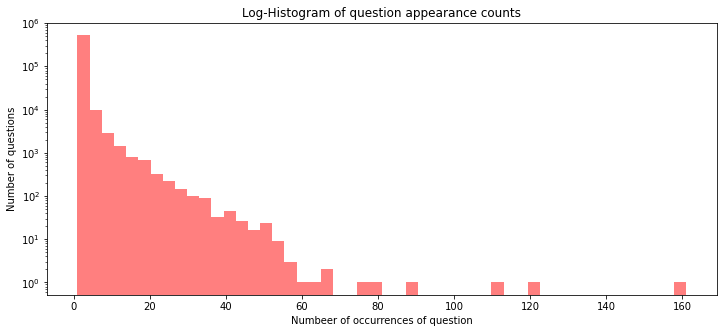

In [30]:
plt.figure(figsize= (12,5))
plt.hist(train_set.value_counts(), bins = 50, alpha = 0.5, color = 'r', label = 'word')
plt.yscale('log', nonposy = 'clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Numbeer of occurrences of question')
plt.ylabel('Number of questions')

In [32]:
print('중복 최대 개수 : {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수 : {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수 : {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차 : {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이 : {}'.format(np.median(train_set.value_counts())))
print('제1사분위 중복 : {}'.format(np.percentile(train_set.value_counts(),25)))
print('제 3사분위 중복 : {}'.format(np.percentile(train_set.value_counts(),75)))

중복 최대 개수 : 161
중복 최소 개수 : 1
중복 평균 개수 : 1.50
중복 표준편차 : 1.91
중복 중간길이 : 1.0
제1사분위 중복 : 1.0
제 3사분위 중복 : 1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x219ea258df0>,
 'caps': [<matplotlib.lines.Line2D at 0x219ea2585e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x219ea2583d0>],
 'medians': [<matplotlib.lines.Line2D at 0x219eabdc8e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x219eabdc6d0>],
 'means': [<matplotlib.lines.Line2D at 0x219eabdcd60>]}

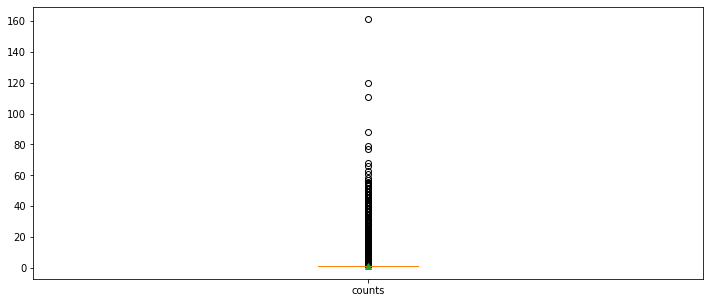

In [34]:
plt.figure(figsize  = (12,5))
plt.boxplot([train_set.value_counts()],
           labels = ['counts'],
           showmeans = True)

### 데이터에 많이 등장한 단어

(-0.5, 799.5, 599.5, -0.5)

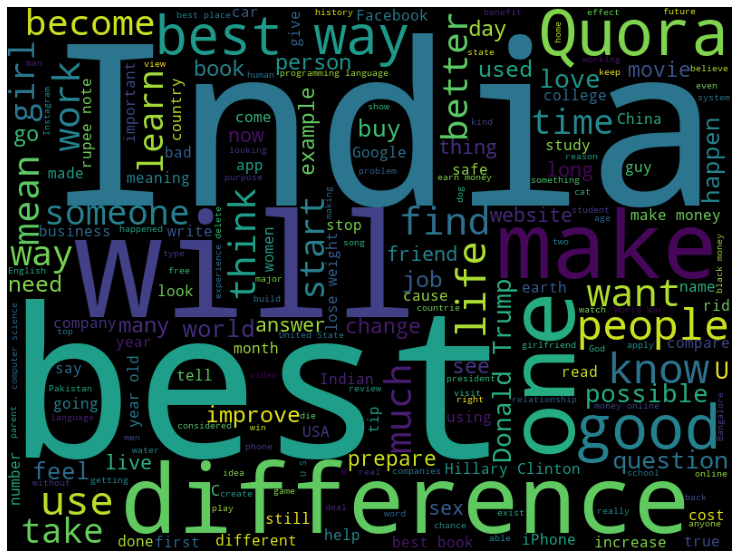

In [36]:
from wordcloud import WordCloud
cloud = WordCloud(width = 800, height = 600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize = (15,10))
plt.imshow(cloud)
plt.axis('off')

C:\ca_da\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

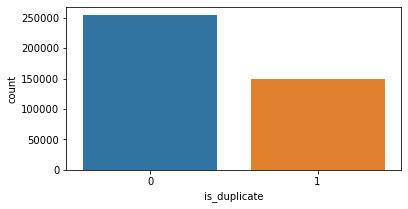

In [37]:
fig, axs = plt.subplots(ncols = 1
                       )
fig.set_size_inches(6,3)
sns.countplot(train_data['is_duplicate'])

In [39]:
train_data['is_duplicate'].value_counts()
#중복이 안된 데이터 25만건, 중복인 데이터 15만건

0    255027
1    149263
Name: is_duplicate, dtype: int64

중복이 안된 데이터가 25만건이고 중복이된 데이터가 15만건이면 25만건 한쪽으로 데이터 비중이 많이 치우쳐져 있음을 알 수 있다.  
최대한 라벨의 개수를 맞추는 게 좋다.

1. 데이터를 줄여서 사용할 수도 있고  
2. 데이터를 늘려서 사용할 수도 있다.


### 텍스트 데이터의 길이

In [41]:
train_length = train_set.apply(len)
train_length

0          66
1          51
2          73
3          50
4          76
         ... 
808575     79
808576     42
808577     17
808578    127
808579     45
Length: 808580, dtype: int64

Text(0, 0.5, 'Probability')

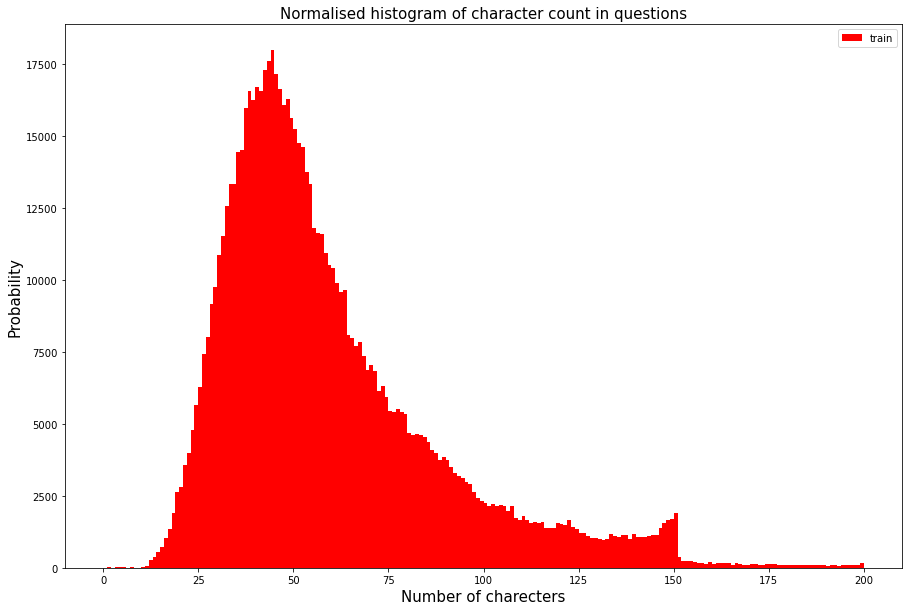

In [45]:
plt.figure(figsize = (15,10))
plt.hist(train_length, bins = 200, range = [0,200], facecolor = 'r',label = 'train')
plt.title('Normalised histogram of character count in questions', fontsize = 15)
plt.legend()
plt.xlabel('Number of charecters', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)

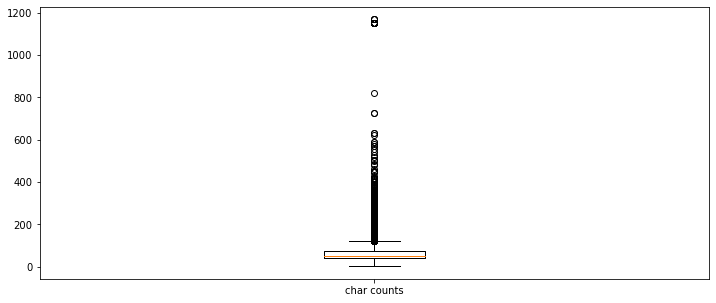

In [46]:
plt.figure(figsize = (12,5))
plt.boxplot(train_length,
           labels = ['char counts'])
showmeans = True


In [47]:
train_set

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
808575    How many keywords are there in PERL Programmin...
808576           Is it true that there is life after death?
808577                                    What's this coin?
808578    I am having little hairfall problem but I want...
808579        What is it like to have sex with your cousin?
Length: 808580, dtype: object

In [48]:
train_words_counts =  train_set.apply(lambda x : len(x.split(' ')))

Text(0, 0.5, 'Probability')

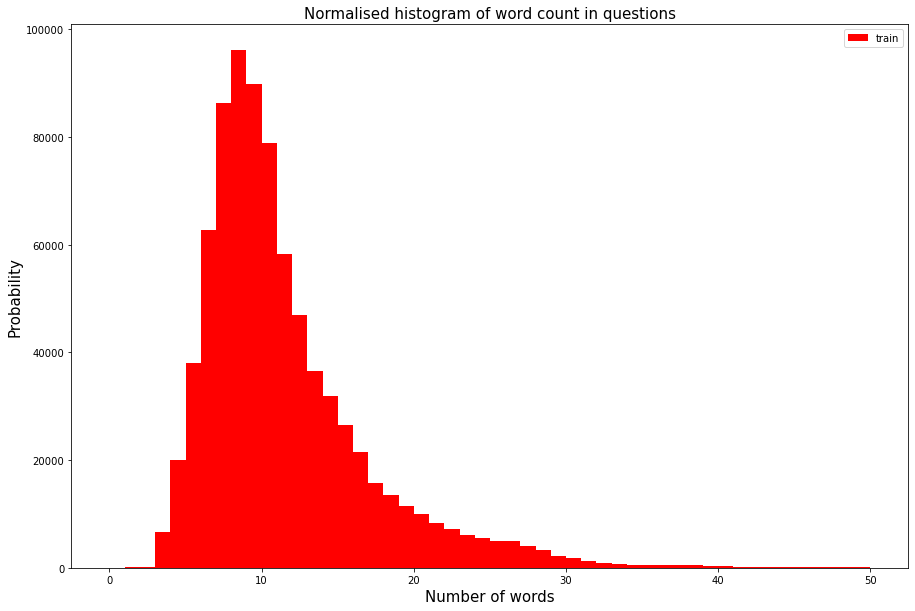

In [52]:
plt.figure(figsize = (15,10))
plt.hist(train_words_counts, bins = 50, range = [0,50], facecolor = 'r', label = 'train')
plt.title('Normalised histogram of word count in questions', fontsize = 15)
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)

{'whiskers': [<matplotlib.lines.Line2D at 0x219f9a38e20>,
 'caps': [<matplotlib.lines.Line2D at 0x219f9a54ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x219e3669400>],
 'medians': [<matplotlib.lines.Line2D at 0x21a22ec4550>],
 'fliers': [<matplotlib.lines.Line2D at 0x219f9a3d3d0>],
 'means': [<matplotlib.lines.Line2D at 0x21a22eba790>]}

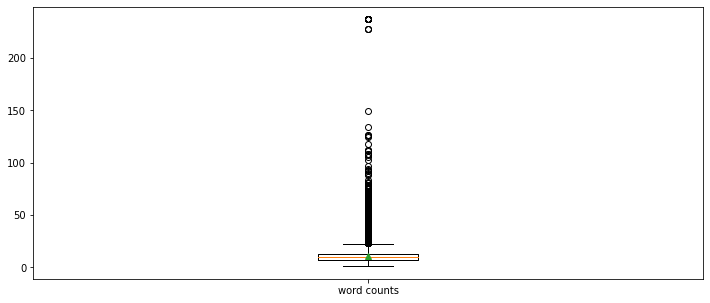

In [57]:
plt.figure(figsize = (12,5))
plt.boxplot(train_words_counts,
           labels = ['word counts'],
           showmeans = True)

### 특수문자 중 구두점, 물음표, 마침표가 사용된 비율과 수학 기호가 사용된 비율, 대/소문자 비율

In [68]:
qmarks = np.mean(train_set.apply(lambda x : '?' in x)) #물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x : '[math]' in x)) #[]
fullstop = np.mean(train_set.apply(lambda x : '.' in x)) #마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #첫 대문자
capitals = np.mean(train_set.apply(lambda x :max([y.isupper() for y in x]))) #대문자가 몇 개?

print('물음표가 있는 질문 : {:.2f}%'.format(qmarks * 100))
print('수학수식이 있는 질문 : {:.2f}%'.format(math * 100))
print('마침표가 있는 질문 : {:.2f}%'.format(fullstop * 100))
print('첫 대문자인 질문 : {:.2f}%'.format(capital_first * 100))
print('대문자의 개수 : {:.2f}%'.format(capitals * 100))



물음표가 있는 질문 : 99.87%
수학수식이 있는 질문 : 0.12%
마침표가 있는 질문 : 6.31%
첫 대문자인 질문 : 99.81%
대문자의 개수 : 99.95%


## 데이터 전처리

In [69]:
import pandas as npd
import numpy as np
import re
import json

### 데이터 불러오기

In [71]:
DATA_IN_PATH = './data_in/'
train_data  = pd.read_csv(DATA_IN_PATH + 'train.csv', encoding = 'utf-8')

### 클래스 불균형 해소

1. 중복인 데이터와 중복이 아닌 데이터로 나누기  
2. 중복이 아닌 개수가 비슷하도록 데이터의 일부를 다시 뽑는다.  

In [77]:
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1] #중복인 데이터
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0] #중복이 아닌 데이터

class_difference = len(train_neg_data) - len(train_pos_data) #두 변수의 길이의 차
sample_frac = 1 - (class_difference / len(train_neg_data)) #적은 데이터의 개수와 많은 데이터의 개수의 비율을 구한다.

#적은 데이터의 개수가 많은 데이터에 대한 비율을 계산.

train_neg_data = train_neg_data.sample(frac = sample_frac) #더 많은 데이터에서 더 적은 데이터 비율만큼만 뽑기


In [78]:
print('중복 질문 개수 : ',len(train_pos_data))
print('중복이 아닌 질문 개수 : ',len(train_neg_data))

중복 질문 개수 :  149263
중복이 아닌 질문 개수 :  149263


In [82]:
train_data = pd.concat([train_pos_data, train_neg_data])
# train_data

### 특수문자 제거 및 소문자 변환

In [94]:
# change_filter = re.compile(FILTERS)

question1 = [str(s) for s in train_data['question1']]
question2 = [str(s) for s in train_data['question2']]

filtered_question1 = list()
filtered_question2 = list()

for q in question1:
    filtered_question1.append(re.sub('[^a-zA-Z]'," ",q).lower())
    
for q in question2:
    filtered_question2.append(re.sub('[^a-zA-Z]'," ",q).lower())

### 단어 token화

In [98]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_question1 + filtered_question2) #전체 질문의 단어들에 대한 단어id 사전 만들기

In [101]:
question1_sequence = tokenizer.texts_to_sequences(filtered_question1) #문장을 단어id 시퀀스 데이터로 만듬
question2_sequence = tokenizer.texts_to_sequences(filtered_question2)


### 입력 데이터 길이 통일

In [106]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 31

q1_data = pad_sequences(question1_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
q2_data = pad_sequences(question2_sequence, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')



### 단어 id 사전

In [109]:
word_vocab = {}
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

labels = np.array(train_data['is_duplicate'], dtype = int)

print('Shape of question1 data : {}'.format(q1_data.shape))
print('Shape of question2 data : {}'.format(q2_data.shape))
print('Shape of label : {}'.format(labels.shape))
print('Words in index : {}'.format(len(word_vocab)))


Shape of question1 data : (298526, 31)
Shape of question2 data : (298526, 31)
Shape of label : (298526,)
Words in index : 64928


In [110]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

### 전처리된 데이터들 저장(label, 단어id사전 포함)

In [115]:
TRAIN_01_DATA = 'q1_train.npy'
TRAIN_02_DATA = 'q2_train.npy'
TRAIN_LABEL_DATA = 'label_train.npy'
DATA_CONFIGS = 'data_configs.npy'

np.save(open(DATA_IN_PATH + TRAIN_01_DATA, 'wb'), q1_data) #q1데이터 저장
np.save(open(DATA_IN_PATH + TRAIN_02_DATA,'wb'),q2_data) #q2 데이터 저장 
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA,'wb'), labels) #라벨 데이터 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS,'w')) #단어 id 사전 저장


### test 데이터 전처리

In [123]:
test_data = pd.read_csv(DATA_IN_PATH + 'test.csv', encoding = 'utf-8')
valid_ids = [type(x) == int for x in test_data.test_id]
test_data = test_data[valid_ids].drop_duplicates()


C:\ca_da\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [126]:
test_question1 = [str(s) for s in test_data['question1']]
test_question2 = [str(s) for s in test_data['question2']]

filtered_test_question1 = list()
filtered_test_question2 = list()

for q in test_question1:
    filtered_test_question1.append(re.sub("[^a-zA-Z]"," ", q).lower())
    
for q in test_question2:
    filtered_test_question2.append(re.sub("[^a-zA-Z]"," ",q).lower())
    
    

### test 데이터 tokenize

In [128]:
#train 에서 만들었던 단어 인덱스를 그대로 사용해야 한다. (tokenizer 객체 그대로 사용)

test_question1_sequence = tokenizer.texts_to_sequences(filtered_test_question1)
test_question2_sequence = tokenizer.texts_to_sequences(filtered_test_question2)

test_q1_data = pad_sequences(test_question1_sequence, maxlen = MAX_SEQUENCE_LENGTH,
                            padding = "post")
test_q2_data = pad_sequences(test_question2_sequence, maxlen = MAX_SEQUENCE_LENGTH,
                            padding = "post")



In [129]:
test_id = np.array(test_data['test_id'])

print('Shape of question1 data : {}'.format(test_q1_data.shape))
print('Shape of question2 data : {}'.format(test_q2_data.shape))
print('Shape of ids: {}'.format(test_id.shape))


Shape of question1 data : (2345796, 31)
Shape of question2 data : (2345796, 31)
Shape of ids: (2345796,)


### test 데이터 저장

In [130]:
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_Q1_DATA,'wb'), test_q1_data)
np.save(open(DATA_IN_PATH + TEST_Q2_DATA, 'wb'), test_q2_data)
np.save(open(DATA_IN_PATH + TEST_ID_DATA,'wb'), test_id)


## 모델링

### XG부스트 모델

- 앙상블 : 여러 학습 모델들을 합치는 것.  
- 배깅 :  같은 알고리즘의 모델들 여러 개를 합치고 각각의 결과들을 취합하여 최종 결론을 내는 유형  
- 부스팅 : 배깅과 똑같이 여러 알고리즘의 결과를 취합하지만 순차적으로 취합하면서, 이전 모델이 잘못 예측한 부분에 대해서 가중치를 줘서 닫시 모델로 가서 학습하는 방식  
- XG부스팅 :  부스팅 기법 중 트리 기반 부스팅 기법 여러 개의 트리 알고리즘을 사용하지만 단순히 결과를 평균 내는 게 아니라, 결과를 보고 오답에 대해서 가중치를 부여하는 방식으로 학습.  
- 즉, XG부스팅은 트리 부스팅 방식에 경사 하강법을 통해서 최적화하는 방법이다.  

#### 전처리된 데이터 불러오기

In [155]:
import numpy as np

DATA_IN_PATH = './data_in/'

TRAIN_Q1_DATA_FILE = 'q1_train.npy'
TRAIN_Q2_DATA_FILE = 'q2_train.npy'
TRAIN_LABEL_DATA_FILE = 'label_train.npy'

#훈련 데이터를 가져온다.

train_q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
train_q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
train_labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))


In [156]:
train_input = np.stack([train_q1_data, train_q2_data], axis = 1)
train_input.shape

(298526, 2, 31)

#### 데이터 분리

In [157]:
from sklearn.model_selection import train_test_split

train_input, eval_input, train_label, eval_label = train_test_split(train_input, train_labels, test_size = 0.2, random_state = 4242)

In [142]:
!pip install xgboost

#### 학습 데이터와 검증 데이터 DMatrix 화 하기

In [158]:
import xgboost as xgb

#xgboost 를 사용하려면 입력값을 DMatrix 형태로 변환해줘야 한다.
#학습 데이터와 검증 데이터 모두 적용한다.
#sum 을 해주는 이유는 각 데이터에 대해 두 질문의 값을 하나의 값으로 만들어 주기 위함임 (array 두 개가 31 차원을 공유하고 있다.)

train_data = xgb.DMatrix(train_input.sum(axis = 1), label = train_label)
eval_data = xgb.DMatrix(eval_input.sum(axis = 1), label = eval_label)

data_list = [(train_data, 'train'),(eval_data,'valid')]

In [159]:
len(train_label)

238820

In [160]:
len(eval_label)

59706

In [161]:
params = {}
params['objective'] = 'binary:logistic' #모델의 목적 함수. 결과는 내기 위한 함수.
params['eval_metric'] = 'rmse' #경사하강법을 사용한다니까 그런듯. 평가 지표.


#num boost round 는 데이터를 반복 학습하는 횟수
#early stopping rounds 는 성능이 그대로이거나 나빠진게 10번이상일떄 학습을 조기 멈추게 해준다.
#epochs = 1000 은 1000번 이걸 반복한다는 의미.

bst = xgb.train(params, train_data, num_boost_round = 1000, evals = data_list,
               early_stopping_rounds = 10)



[0]	train-rmse:0.48444	valid-rmse:0.48446
[1]	train-rmse:0.47419	valid-rmse:0.47415
[2]	train-rmse:0.46766	valid-rmse:0.46772
[3]	train-rmse:0.46333	valid-rmse:0.46349
[4]	train-rmse:0.45970	valid-rmse:0.46003
[5]	train-rmse:0.45714	valid-rmse:0.45757
[6]	train-rmse:0.45526	valid-rmse:0.45582
[7]	train-rmse:0.45200	valid-rmse:0.45265
[8]	train-rmse:0.45086	valid-rmse:0.45164
[9]	train-rmse:0.44972	valid-rmse:0.45069
[10]	train-rmse:0.44793	valid-rmse:0.44902
[11]	train-rmse:0.44695	valid-rmse:0.44813
[12]	train-rmse:0.44643	valid-rmse:0.44767
[13]	train-rmse:0.44591	valid-rmse:0.44732
[14]	train-rmse:0.44487	valid-rmse:0.44632
[15]	train-rmse:0.44453	valid-rmse:0.44609
[16]	train-rmse:0.44383	valid-rmse:0.44558
[17]	train-rmse:0.44272	valid-rmse:0.44459
[18]	train-rmse:0.44100	valid-rmse:0.44306
[19]	train-rmse:0.44075	valid-rmse:0.44292
[20]	train-rmse:0.43990	valid-rmse:0.44234
[21]	train-rmse:0.43967	valid-rmse:0.44218
[22]	train-rmse:0.43943	valid-rmse:0.44208
[23]	train-rmse:0.439

[189]	train-rmse:0.40489	valid-rmse:0.42527
[190]	train-rmse:0.40486	valid-rmse:0.42526
[191]	train-rmse:0.40483	valid-rmse:0.42524
[192]	train-rmse:0.40468	valid-rmse:0.42521
[193]	train-rmse:0.40442	valid-rmse:0.42514
[194]	train-rmse:0.40440	valid-rmse:0.42514
[195]	train-rmse:0.40438	valid-rmse:0.42512
[196]	train-rmse:0.40421	valid-rmse:0.42508
[197]	train-rmse:0.40419	valid-rmse:0.42508
[198]	train-rmse:0.40409	valid-rmse:0.42503
[199]	train-rmse:0.40402	valid-rmse:0.42502
[200]	train-rmse:0.40368	valid-rmse:0.42495
[201]	train-rmse:0.40332	valid-rmse:0.42472
[202]	train-rmse:0.40301	valid-rmse:0.42464
[203]	train-rmse:0.40272	valid-rmse:0.42454
[204]	train-rmse:0.40248	valid-rmse:0.42450
[205]	train-rmse:0.40222	valid-rmse:0.42447
[206]	train-rmse:0.40211	valid-rmse:0.42445
[207]	train-rmse:0.40204	valid-rmse:0.42444
[208]	train-rmse:0.40180	valid-rmse:0.42437
[209]	train-rmse:0.40177	valid-rmse:0.42437
[210]	train-rmse:0.40152	valid-rmse:0.42432
[211]	train-rmse:0.40141	valid-r

[376]	train-rmse:0.38185	valid-rmse:0.42002
[377]	train-rmse:0.38185	valid-rmse:0.42002
[378]	train-rmse:0.38180	valid-rmse:0.41999
[379]	train-rmse:0.38178	valid-rmse:0.41997
[380]	train-rmse:0.38177	valid-rmse:0.41997
[381]	train-rmse:0.38169	valid-rmse:0.41997
[382]	train-rmse:0.38157	valid-rmse:0.41996
[383]	train-rmse:0.38143	valid-rmse:0.41997
[384]	train-rmse:0.38132	valid-rmse:0.41999
[385]	train-rmse:0.38123	valid-rmse:0.41995
[386]	train-rmse:0.38107	valid-rmse:0.41991
[387]	train-rmse:0.38102	valid-rmse:0.41990
[388]	train-rmse:0.38083	valid-rmse:0.41984
[389]	train-rmse:0.38057	valid-rmse:0.41979
[390]	train-rmse:0.38044	valid-rmse:0.41977
[391]	train-rmse:0.38022	valid-rmse:0.41977
[392]	train-rmse:0.38007	valid-rmse:0.41980
[393]	train-rmse:0.37999	valid-rmse:0.41978
[394]	train-rmse:0.37985	valid-rmse:0.41976
[395]	train-rmse:0.37969	valid-rmse:0.41976
[396]	train-rmse:0.37958	valid-rmse:0.41974
[397]	train-rmse:0.37943	valid-rmse:0.41967
[398]	train-rmse:0.37927	valid-r

[563]	train-rmse:0.36128	valid-rmse:0.41705
[564]	train-rmse:0.36106	valid-rmse:0.41703
[565]	train-rmse:0.36091	valid-rmse:0.41697
[566]	train-rmse:0.36082	valid-rmse:0.41698
[567]	train-rmse:0.36069	valid-rmse:0.41699
[568]	train-rmse:0.36051	valid-rmse:0.41696
[569]	train-rmse:0.36043	valid-rmse:0.41696
[570]	train-rmse:0.36028	valid-rmse:0.41693
[571]	train-rmse:0.36009	valid-rmse:0.41689
[572]	train-rmse:0.35999	valid-rmse:0.41687
[573]	train-rmse:0.35978	valid-rmse:0.41683
[574]	train-rmse:0.35968	valid-rmse:0.41683
[575]	train-rmse:0.35959	valid-rmse:0.41681
[576]	train-rmse:0.35948	valid-rmse:0.41682
[577]	train-rmse:0.35929	valid-rmse:0.41680
[578]	train-rmse:0.35924	valid-rmse:0.41680
[579]	train-rmse:0.35909	valid-rmse:0.41680
[580]	train-rmse:0.35892	valid-rmse:0.41679
[581]	train-rmse:0.35872	valid-rmse:0.41674
[582]	train-rmse:0.35856	valid-rmse:0.41671
[583]	train-rmse:0.35838	valid-rmse:0.41666
[584]	train-rmse:0.35828	valid-rmse:0.41666
[585]	train-rmse:0.35807	valid-r

#### test 데이터 불러오기

In [163]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE,'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE,'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE,'rb'), allow_pickle = True)


#### test 데이터 DMatrix 변환 후 예측 결과값 내기

In [165]:
test_input = np.stack((test_q1_data, test_q2_data), axis = 1)
test_data = xgb.DMatrix(test_input.sum(axis = 1))
test_predict = bst.predict(test_data)


### CNN 모델

감성분석에서의 CNN 과 유사하지만, 이번 데이터는 각 텍스트 문서가 두 개로 되어 있기 때문에 두 데이터를 병렬적인 구조를 가진 모델을 만든다.

기존 문장 : 기준이 되는 문장  
대상 문장 : 대상이 되는 문장  
예 : I love deep NLP 를 기준문장으로 두고 그것과 비교할 대상을 Deep NLP is awesome 으로 두고 유사하지 유사하지 않은지 비교한다.  

#### 데이터 불러오기

In [175]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_Q1_DATA_FILE = 'q1_train.npy'
TRAIN_Q2_DATA_FILE = 'q2_train.npy'
TRAIN_LABEL_DATA_FILE = 'label_train.npy'
DATA_CONFIGS = 'data_configs.npy'

q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS , 'r'))

#### Sentence Embedding layer 구현

문장을 하나의 벡터로

In [218]:
import tensorflow as tf

class SentenceEmbedding(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()
        
        self.conv = tf.keras.layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'],
                                          activation = tf.keras.activations.relu,
                                          padding = 'same')
        
        self.max_pool = tf.keras.layers.MaxPool1D(kargs['max_pool_seq_len'],1)
        self.dense = tf.keras.layers.Dense(kargs['sent_embedding_dimension'],
                                 activation = tf.keras.activations.relu)
        
        
    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)
    

#### Sentence Similarity layer 구현

In [219]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel,self).__init__(name =kargs['model_name'])
        
        self.word_embedding = tf.keras.layers.Embedding(kargs['vocab_size'],
                                                       kargs['word_embedding_dimension'])
        
        self.base_encoder = SentenceEmbedding(**kargs) #기존 문장
        self.hypo_encoder = SentenceEmbedding(**kargs) #비교할 대상 문장
        self.dense = tf.keras.layers.Dense(kargs['hidden_dimension'],
                                          activation = tf.keras.activations.relu)
        
        self.logit = tf.keras.layers.Dense(1, activation= tf.keras.activations.sigmoid)
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        x1, x2 = x
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x,h_x],-1)
        
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)
        
        return self.logit(e_x)
    
    
        
        
        

#### 모델 하이퍼파라미터 정의

In [220]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'word_embedding_dimension' : 100,
        'conv_num_filters' : 300,
        'conv_window_size' : 3,
        'max_pool_seq_len' : MAX_LEN,
        'sent_embedding_dimension' : 128,
        'dropout_rate' : 0.2,
        'hidden_dimension' : 200,
        'output_dimension' : 1}



#### 모델 생성

In [225]:
model = SentenceSimilarityModel(**kargs)

model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])


#### 모델 학습

In [226]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [227]:
earlystop_callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 1)

checkpoint_path = DATA_IN_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
    
else:
    os.makedirs(checkpoint_dir, exist_ok = True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
    
    
cp_callback = ModelCheckpoint(checkpoint_path,
                             monitor = 'val_accuracy',
                             verbose = 1,
                             save_best_only = True,
                             save_weights_only = True)




./data_in/cnn_similarity -- Folder already exists 



In [228]:
history = model.fit((q1_data, q2_data), labels, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                   validation_split = VALID_SPLIT, callbacks = [earlystop_callback,
                                                               cp_callback])

Epoch 1/100
263/263 [==============================] - 253s 951ms/step - loss: 0.5512 - accuracy: 0.7130 - val_loss: 0.6501 - val_accuracy: 0.6911

Epoch 00001: val_accuracy improved from -inf to 0.69105, saving model to ./data_in/cnn_similarity\weights.h5
Epoch 2/100
263/263 [==============================] - 244s 930ms/step - loss: 0.4501 - accuracy: 0.7875 - val_loss: 0.5769 - val_accuracy: 0.7046

Epoch 00002: val_accuracy improved from 0.69105 to 0.70462, saving model to ./data_in/cnn_similarity\weights.h5
Epoch 3/100
263/263 [==============================] - 243s 923ms/step - loss: 0.3628 - accuracy: 0.8376 - val_loss: 0.5831 - val_accuracy: 0.7128

Epoch 00003: val_accuracy improved from 0.70462 to 0.71279, saving model to ./data_in/cnn_similarity\weights.h5
Epoch 4/100
263/263 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8796

KeyboardInterrupt: 

### LSTM(MaLSTM) 모델

일반적으로 문장의 유사도를 측정할 때 "코사인 유사도" 를 사용하는 게 아닌 맨하튼 거리를 사용하는 모델이다.

#### 모델 구현

In [ ]:
class Model(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(Model,self).__init__(name=model_name)
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'],
                                                  output_dim = kargs['embedding_dimension'])
        
        self.lstm = tf.keras.layers.LSTM(units = kargs['lstm_dimension'])
        
    def call(self,x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        x = tf.exp(-tf.reduce_sum(tf.abs(x1-x2), axis = 1)) #맨하튼 거리 계산
        #x1-x2 한 값을 절댓값 씌우고 두 벡터 간의 원소 간의 차이에 대한 절댓값 합을 계산하다.
        
        return x        

#### 모델 하이퍼파라미터 정의 및 학습 정의

In [ ]:
model_name = 'malstm_similarity'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {
    'vocab_size' : prepro_configs['vocab_size'],
    'embedding_dimension' : 100,
    'lstm_dimension' : 150
}

model = Model(**kargs)

model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])


#### call back 설정

In [230]:
earlystop_callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 1)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dif))
else:
    os.makedirs(checkpoint_dir, exist_ok = True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

./data_out/cnn_similarity -- Folder create complete 



In [232]:
cp_callback = ModelCheckpoint(
checkpoint_path,monitor = 'val_accuracy',
verbose = 1,
save_best_only = True,
save_weights_only = True)

history = model.fit((q1_data, q2_data), labels, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                   validation_split = VALID_SPLIT, callbacks = [earlystop_callback,
                                                               cp_callback])


Epoch 1/100
  6/263 [..............................] - ETA: 5:05 - loss: 0.2071 - accuracy: 0.9207

KeyboardInterrupt: 